# New Section

In [ ]:
!pip install basemap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.colors as mclr
import matplotlib.pyplot as plt
import networkx as nx
import random
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.animation import FuncAnimation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import geopy.distance as dist
home = "/content/drive/MyDrive/SeniorProject/"
data = pd.read_csv(home + "FAF5.5.1_2018-2022.csv")

# Filter only 2022 data
columns = ["fr_orig", "dms_orig", "dms_dest", "fr_dest", "fr_inmode", "dms_mode", "fr_outmode", "sctg2", "trade_type", "tons_2022", "current_value_2022"]
data = data[columns]

# Domestic-only
dms_data = data[data["trade_type"] == 1]
stats_data = comod_data = dms_data

# Truck-only
dms_data = data[data["dms_mode"] == 1]

# Get state/city names
cfs_df = pd.read_csv(home + "cfs_names.csv")
cfs_df = cfs_df[["FAF", "CFSMA", "CFSAREANAM", "SHORTNAME", "STPOSTAL"]]

# Filter out "rest of..." metro areas
cfs_df = cfs_df[cfs_df["CFSMA"] != 99999]

# Filter out non-west states
western_states = ["CA", "OR", "WA", "NV", "ID", "UT", "CO", "WY", "MT"]
cfs_west_df = cfs_df[cfs_df["STPOSTAL"].isin(western_states)]

# Merge lat/lon
regions_df = pd.read_csv(home + "regions.csv")
regions_df = regions_df[["faf_zone", "intptlat", "intptlon"]]
cfs_df = pd.merge(cfs_df, regions_df, left_on="FAF", right_on="faf_zone").rename(columns={"intptlat": "latitude", "intptlon": "longitude"})

# Merge origin on state/city names
dms_data = pd.merge(dms_data, cfs_df, left_on="dms_orig", right_on="FAF")
dms_data.rename(columns={"CFSMA": "CFSMA_orig", "CFSAREANAM": "placename_orig", "SHORTNAME": "short_placename_orig", "STPOSTAL": "abbr_orig", "latitude": "latitude_orig", "longitude": "longitude_orig"}, inplace=True)
del dms_data["FAF"]

# Merge destination on state/city names
dms_data = pd.merge(dms_data, cfs_df, left_on="dms_dest", right_on="FAF")
dms_data.rename(columns={"CFSMA": "CFSMA_dest", "CFSAREANAM": "placename_dest", "SHORTNAME": "short_placename_dest", "STPOSTAL": "abbr_dest", "latitude": "latitude_dest", "longitude": "longitude_dest"}, inplace=True)
del dms_data["FAF"]

# Filter out shipments with the same origin/destination
dms_data = dms_data[dms_data["CFSMA_orig"] != dms_data["CFSMA_dest"]]

# Calculate pair distance
def calcluate_distance(row):
    try:
        return dist.geodesic((row["latitude_orig"], row["longitude_orig"]), (row["latitude_dest"], row["longitude_dest"])).miles
    except:
        return -1
dms_data['distance'] = dms_data.apply(calcluate_distance, axis=1)

dms_data["pair"] = dms_data["short_placename_orig"] + "-" + dms_data["short_placename_dest"]
dms_data

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,tons_2022,...,longitude_orig,CFSMA_dest,placename_dest,short_placename_dest,abbr_dest,faf_zone_y,latitude_dest,longitude_dest,distance,pair
194,NaN,12,11,NaN,NaN,1,NaN,3,1,5.784542,...,-88.196568,142,"Birmingham-Hoover-Talladega, AL CFS Area",Birmingham,AL,11,33.977357,-86.566440,246.107693,Mobile-Birmingham
195,NaN,12,11,NaN,NaN,1,NaN,5,1,0.985969,...,-88.196568,142,"Birmingham-Hoover-Talladega, AL CFS Area",Birmingham,AL,11,33.977357,-86.566440,246.107693,Mobile-Birmingham
196,NaN,12,11,NaN,NaN,1,NaN,6,1,0.198220,...,-88.196568,142,"Birmingham-Hoover-Talladega, AL CFS Area",Birmingham,AL,11,33.977357,-86.566440,246.107693,Mobile-Birmingham
197,NaN,12,11,NaN,NaN,1,NaN,7,1,0.000117,...,-88.196568,142,"Birmingham-Hoover-Talladega, AL CFS Area",Birmingham,AL,11,33.977357,-86.566440,246.107693,Mobile-Birmingham
198,NaN,12,11,NaN,NaN,1,NaN,8,1,0.000636,...,-88.196568,142,"Birmingham-Hoover-Talladega, AL CFS Area",Birmingham,AL,11,33.977357,-86.566440,246.107693,Mobile-Birmingham
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407817,NaN,111,42,NaN,NaN,1,NaN,43,1,0.064525,...,-77.017229,536,"Tucson-Nogales, AZ CFS Area",Tucson,AZ,42,32.128523,-111.783027,2001.551507,Washington (DC)-Tucson
407818,NaN,111,42,802.0,NaN,1,1.0,3,3,0.000000,...,-77.017229,536,"Tucson-Nogales, AZ CFS Area",Tucson,AZ,42,32.128523,-111.783027,2001.551507,Washington (DC)-Tucson
407819,NaN,111,42,802.0,NaN,1,1.0,24,3,0.000000,...,-77.017229,536,"Tucson-Nogales, AZ CFS Area",Tucson,AZ,42,32.128523,-111.783027,2001.551507,Washington (DC)-Tucson
407820,NaN,111,42,802.0,NaN,1,1.0,33,3,0.000000,...,-77.017229,536,"Tucson-Nogales, AZ CFS Area",Tucson,AZ,42,32.128523,-111.783027,2001.551507,Washington (DC)-Tucson


In [ ]:
stats_data = stats_data[stats_data["dms_mode"] == 1]
totals = stats_data.groupby("dms_mode").sum()[["tons_2022", "current_value_2022"]]

print("Thousands of Tons - Highway: " + str(totals.loc[1, "tons_2022"]))
print("Millions of Dollars - Highway: " + str(totals.loc[1, "current_value_2022"]))

Thousands of Tons - Highway: 11746961.618836
Millions of Dollars - Highway: 15116320.514106


In [ ]:
top_pairs = dms_data.groupby(["pair", "distance", "short_placename_orig", "short_placename_dest"]).sum()["tons_2022"].reset_index()
top_pairs.sort_values(by=["tons_2022"], ascending=False, inplace=True)
top_pairs

,pair,distance,short_placename_orig,short_placename_dest,tons_2022
1567,Dallas-Houston,280.728498,Dallas,Houston,24508.045866
3230,Los Angeles-San Francisco,356.547501,Los Angeles,San Francisco,17560.178753
3229,Los Angeles-San Diego,164.025791,Los Angeles,San Diego,17420.114578
5796,San Francisco-Los Angeles,356.547501,San Francisco,Los Angeles,15349.411839
5623,San Antonio-Houston,209.810457,San Antonio,Houston,14371.889607
...,...,...,...,...,...
2983,Lake Charles-Richmond,1046.243439,Lake Charles,Richmond,0.000047
5041,Portland (WA)-Corpus Christi,1873.771277,Portland (WA),Corpus Christi,0.000043
4191,New York (PA)-Portland (WA),2365.110690,New York (PA),Portland (WA),0.000039
1467,Corpus Christi-Birmingham,737.669520,Corpus Christi,Birmingham,0.000000


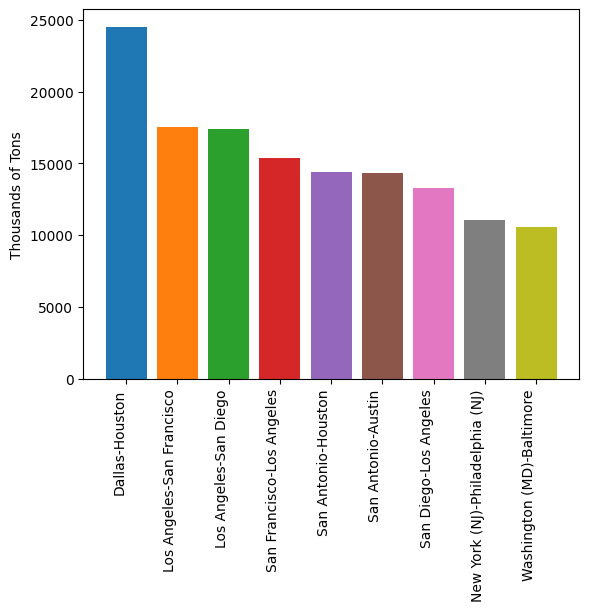

In [ ]:
# Top 10 City Pairs
top10_pairs = top_pairs.iloc[:9]

def make_bar_chart(data):
    data_top10 = data.iloc[:9]
    plt.xticks(rotation=90, ha='right')
    plt.ylabel("Thousands of Tons")

    for i in data_top10.index:
        row = data_top10.loc[i]
        plt.bar(row["pair"], row["tons_2022"])

    plt.show()

make_bar_chart(top10_pairs)

In [ ]:
def remove_random_edge(G, num_requested_edges):
    edge_list = list(G.edges())
    removed_edges = random.sample(edge_list, num_requested_edges)
    G.remove_edges_from(removed_edges)
    return removed_edges

def remove_random_node(G):
    node_list = list(G.nodes())
    node_to_remove = random.choice(node_list)
    G.remove_node(node_to_remove)
    return node_to_remove

def get_stats(G):
    stats = {}
    if nx.is_strongly_connected(G):
        stats['distance_centrality'] = nx.average_shortest_path_length(G)
    else:
        stats['distance_centrality'] = float('inf')
    stats['closeness'] = nx.closeness_centrality(G)
    return stats

def simulate_random_removal(G, num_sims, num_requested_edges):
    results = []
    for _ in range(num_sims):
        G_copy_cat = G.copy()
        remove_random_edge(G_copy_cat, num_requested_edges)  # remove one edge
        stats = get_stats(G_copy_cat)
        results.append(stats)

    # centrality, closeness
    avg_results = {}
    avg_results['distance_centrality'] = np.mean([result['distance_centrality'] for result in results])
    closeness_avg = {node: [] for node in G.nodes()}

    # get avg closeness values for each node
    for result in results:
        for node, centrality in result['closeness'].items():
            closeness_avg[node].append(centrality)

    # add closeness to avg_results
    avg_results['closeness'] = {node: np.mean(centralities) for node, centralities in closeness_avg.items()}
    return avg_results

In [ ]:
# Use Dijkstra's Alg. to find next shortest path
def find_alt_path(graph, node_orig, node_dest):
    try:
        alternate_path = nx.dijkstra_path(graph, source=node_orig, target=node_dest, weight="dist")
        alternate_path_length = nx.dijkstra_path_length(graph, source=node_orig, target=node_dest, weight="dist")
        print("Alternate Path from " + node_orig + " to " + node_dest + " is: ", alternate_path)
        print("Alternate Path Length: ", alternate_path_length)
        return alternate_path
    except:
        print("No Alternate Path Found between " + node_orig + " and " + node_dest)
        return None

In [ ]:
G = nx.DiGraph()

# Add edges
for index, row in top_pairs.iterrows():
  if row["tons_2022"] > 0.0:
    G.add_edge(row["short_placename_orig"], row["short_placename_dest"], tons=row["tons_2022"], original_tons=row["tons_2022"], dist=row["distance"])

# copying G here for random removal simulation
G_copy1 = G.copy()
G_copy2 = G.copy()

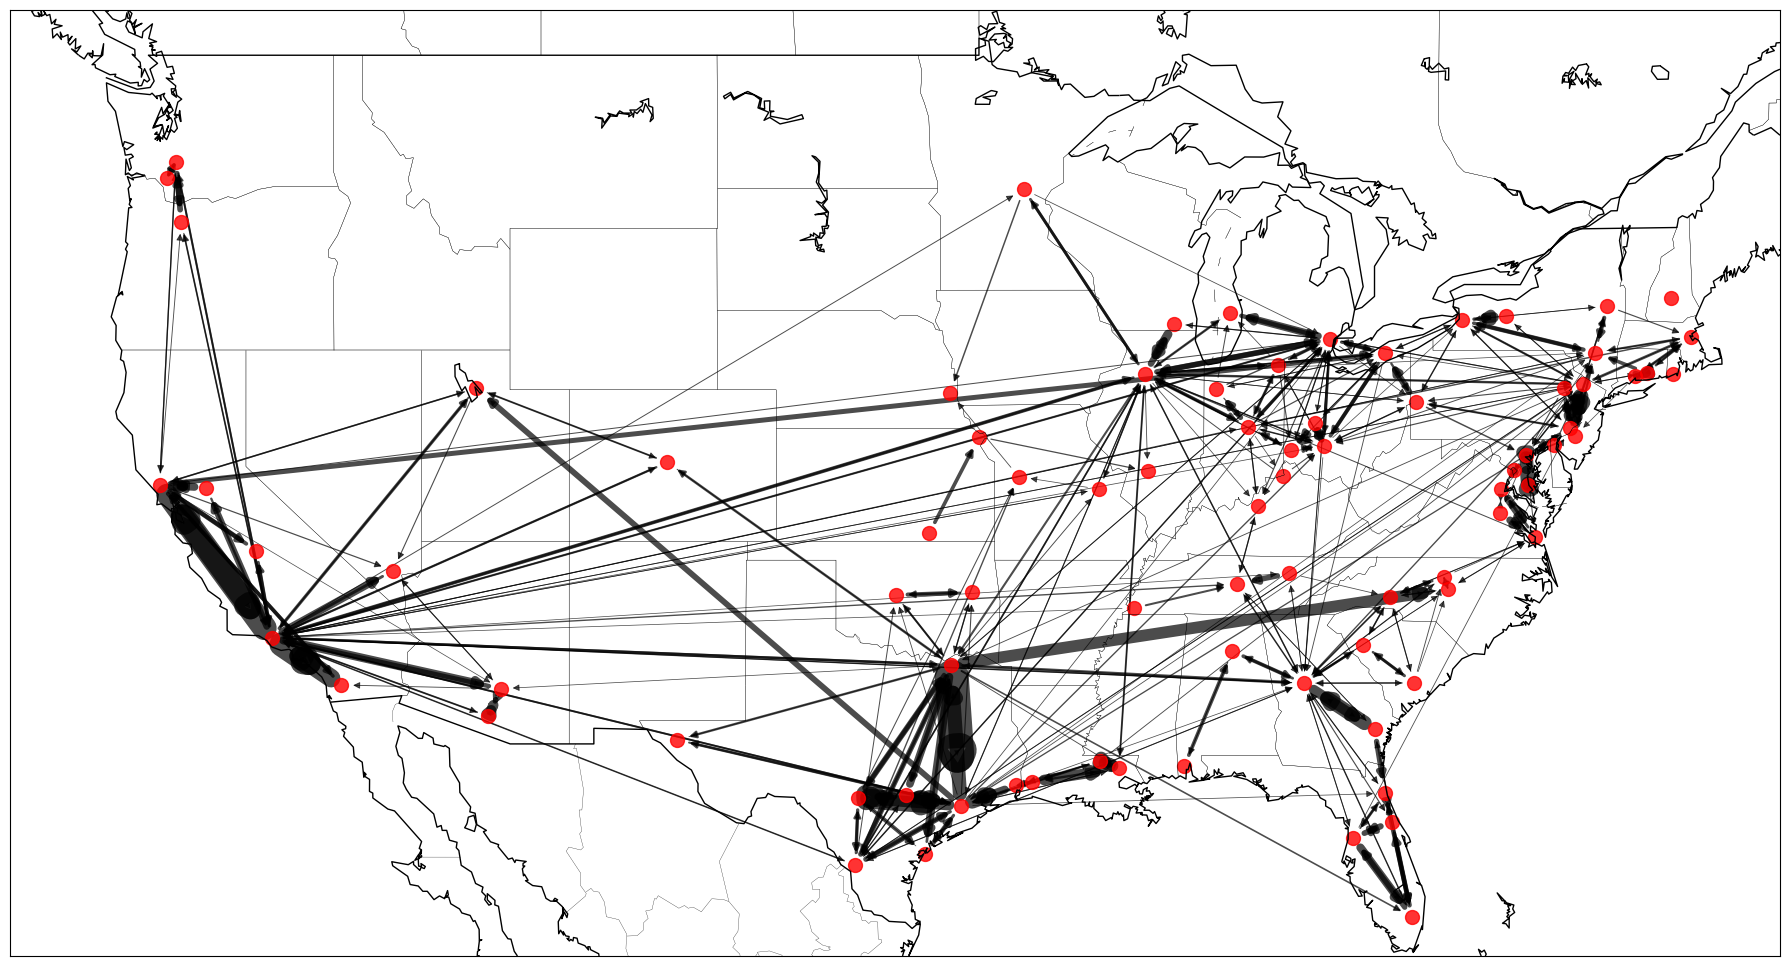

In [ ]:
G_trimmed = G.copy()

# > 500,000 tons
cutoff = 500

for edge in G.edges:
    if G.get_edge_data(edge[0], edge[1])["tons"] < cutoff:
        G_trimmed.remove_edge(edge[0], edge[1])

# Display the full Graph on a basemap map
plt.figure(figsize = (18,18))

m = Basemap(
    projection='merc',
    llcrnrlon=-128,
    llcrnrlat=25,
    urcrnrlon=-68,
    urcrnrlat=50,
    lat_ts=0,
    resolution='l',
    suppress_ticks=True)

pos_df = cfs_df.set_index("SHORTNAME")
pos = {node: m(pos_df.loc[node]["longitude"], pos_df.loc[node]["latitude"]) for node in pos_df.index}
width = [(G_trimmed.get_edge_data(edge[0], edge[1])["tons"]) / 1000 for edge in nx.edges(G_trimmed)]
# add attributes to basemap
nx.draw_networkx_nodes(G = G_trimmed, pos = pos, nodelist = G.nodes(),
                       node_color = 'r', alpha = 0.8, node_size = 100)

nx.draw_networkx_edges(G = G_trimmed, pos = pos, width=width,
                       alpha=0.7, arrows = True)
m.drawcountries(linewidth = 1)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=1)
plt.tight_layout()
plt.show()

Edges: 413
Degree Distribution: [2, 2, 6, 3, 8, 8, 11, 6, 6, 5, 3, 4, 0, 3, 1, 1, 0, 3, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Avg degree: 17.574468085106382
Avg clustering coefficient: 0.5260861986823692


Atlanta             0.502109
Los Angeles         0.487449
Detroit             0.477003
Chicago (IL)        0.470285
Dallas              0.460555
                      ...   
Kansas City (KS)    0.012195
Memphis             0.000000
Wichita             0.000000
Boston (NH)         0.000000
Rhode Island        0.000000
Length: 83, dtype: float64

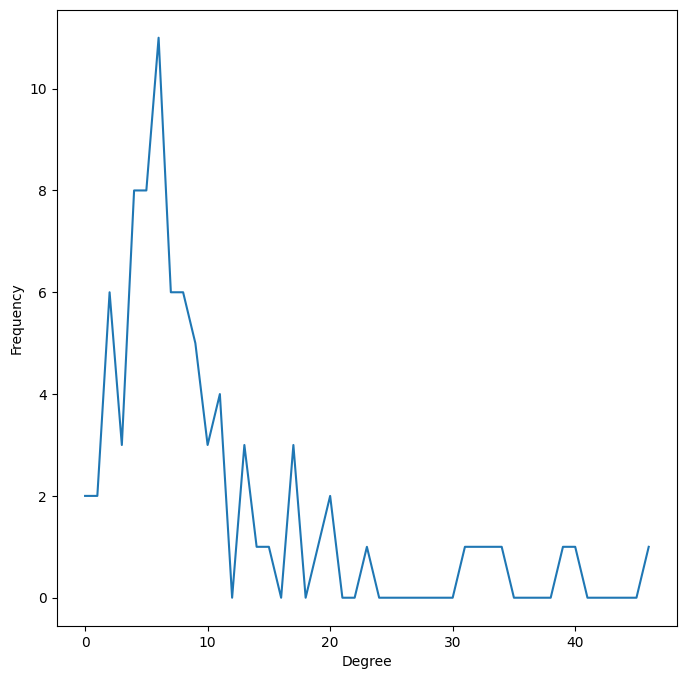

In [ ]:
degree_hist = nx.degree_histogram(G_trimmed)
print("Edges: " + str(len(G_trimmed.edges)))
print("Degree Distribution: " + str(degree_hist))

plt.figure(figsize=(8,8))
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.plot(range(len(degree_hist)), [degree_hist[i] for i in range(len(degree_hist))])

print("Avg degree: " + str(sum([degree_hist[i] * i for i in range(len(degree_hist))]) / len(degree_hist)))
# print("Avg shortest path: " + str(nx.average_shortest_path_length(G_trimmed)))
print("Avg clustering coefficient: " + str(nx.average_clustering(G_trimmed)))

stats = get_stats(G_trimmed)

closeness = pd.Series(stats['closeness'])
closeness.sort_values(ascending=False)

Alternate Path from Dallas to Houston is:  ['Dallas', 'Austin', 'Houston']
Alternate Path Length:  387.7259636384428
Alternate Path from Los Angeles to San Francisco is:  ['Los Angeles', 'Fresno', 'San Francisco']
Alternate Path Length:  384.93537645690367
Alternate Path from Los Angeles to San Diego is:  ['Los Angeles', 'Fresno', 'San Diego']
Alternate Path Length:  473.30755313933196


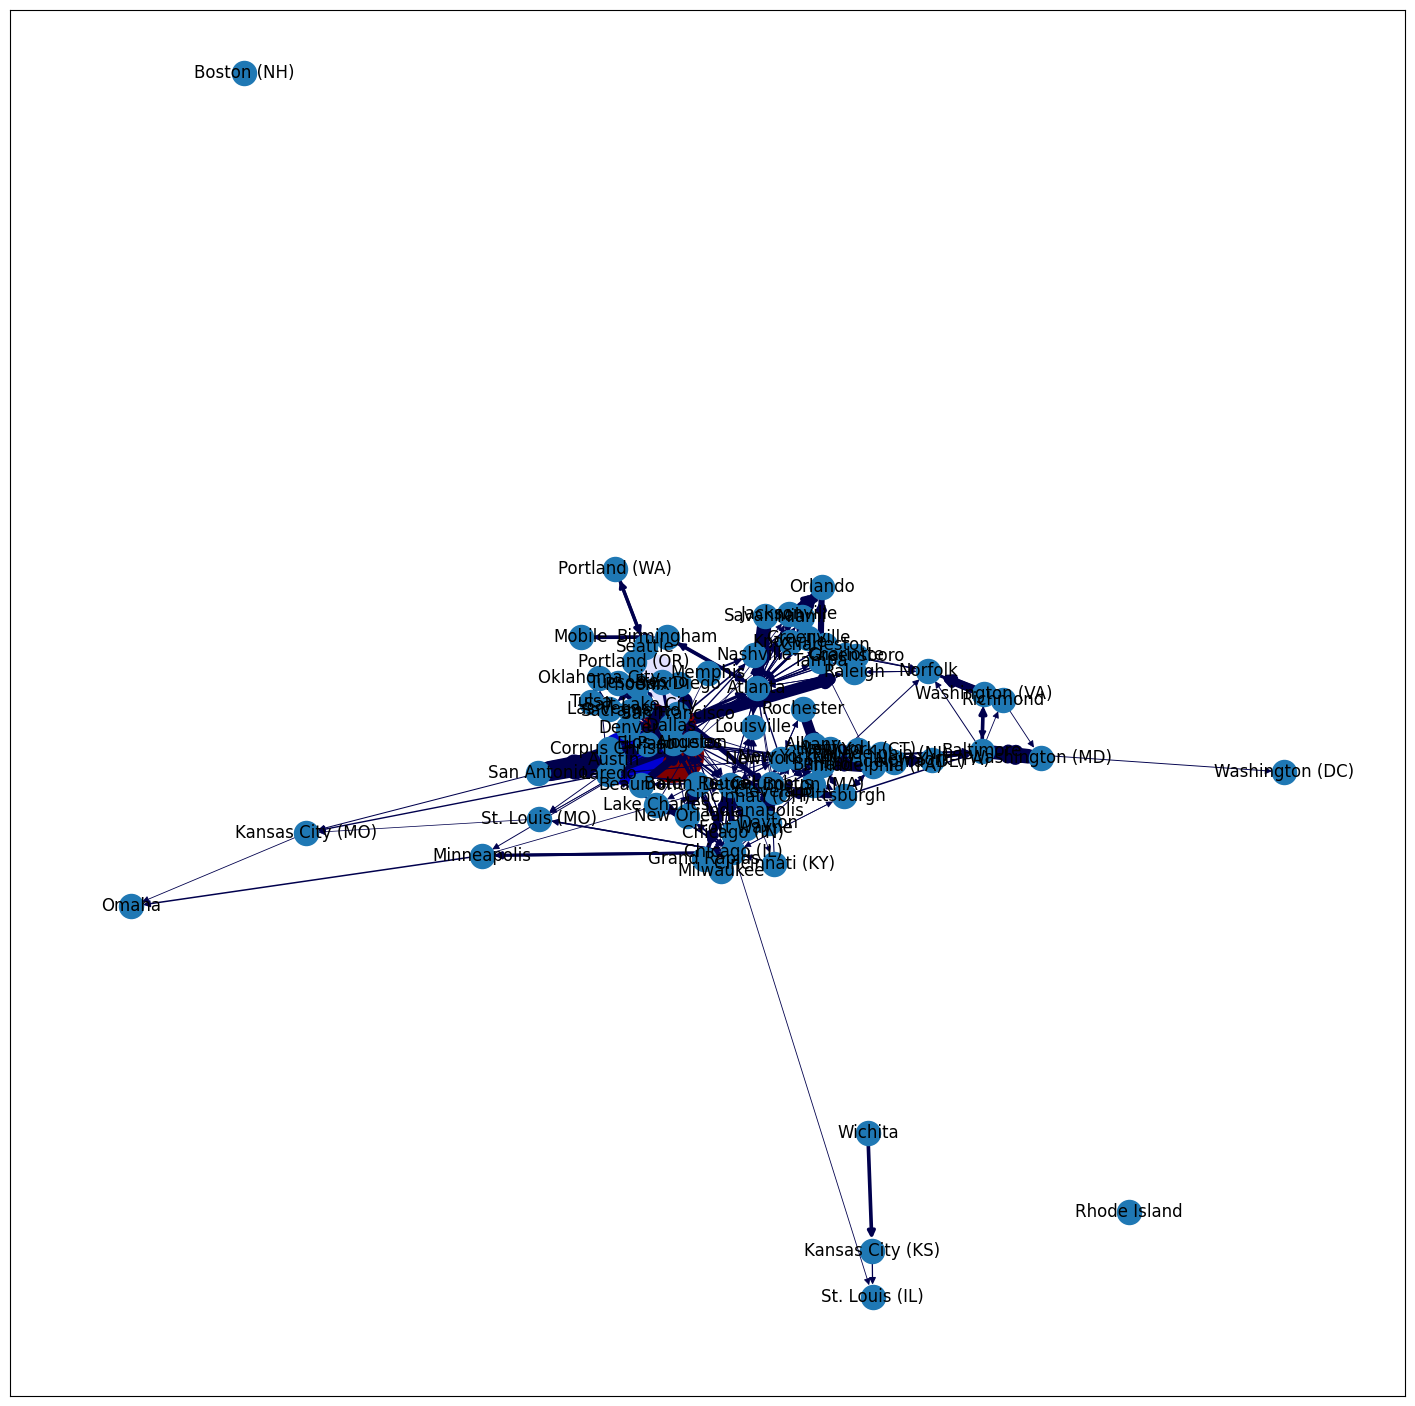

In [ ]:
# Remove the top 3 city pairs (Dallas -> Austin, Los Angeles -> San Francisco, Los Angeles -> San Diego)
G_copy = G.copy()
num_edges = 3
to_remove = top_pairs
for i in range(num_edges):
    orig = to_remove.iloc[i]["short_placename_orig"]
    dest = top_pairs.iloc[i]["short_placename_dest"]
    tons = G_copy.get_edge_data(orig, dest)["tons"]
    G_copy.remove_edge(orig, dest)
    path = find_alt_path(G_copy, orig, dest)
    if path is None:
        print("error.")
        break
    else:
        for j in range(len(path) - 1):
            G_copy.get_edge_data(path[j], path[j + 1])["tons"] += tons

cutoff = 500

for edge in G.edges:
    if G.get_edge_data(edge[0], edge[1])["tons"] < cutoff:
        G_copy.remove_edge(edge[0], edge[1])

# width represents tons of cargo
width = [(G_copy.get_edge_data(edge[0], edge[1])["tons"]) / 1000 for edge in nx.edges(G_copy)]

#color represents change from original value
colors = [(G_copy.get_edge_data(edge[0], edge[1])["tons"]) / (G_copy.get_edge_data(edge[0], edge[1])["original_tons"]) for edge in nx.edges(G_copy)]

plt.figure(figsize=(18,18))
nx.draw_networkx(G_copy, arrows=True, width=width, edge_color=colors, edge_cmap=plt.cm.seismic)
plt.show()


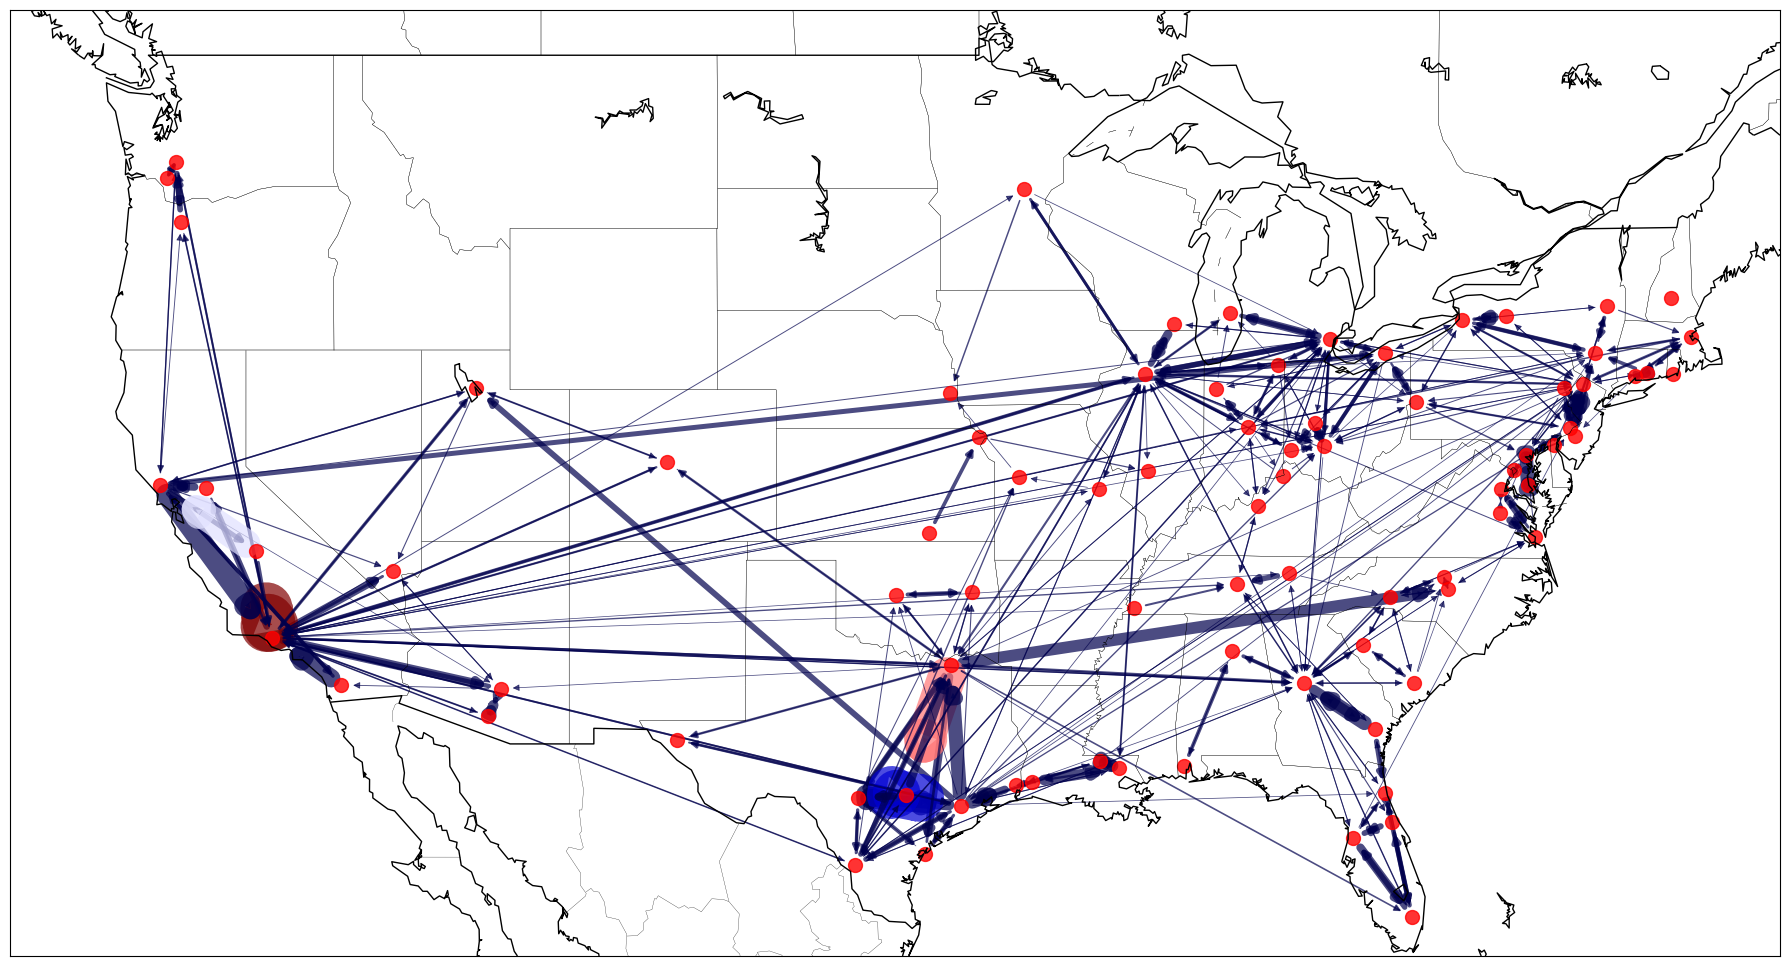

In [ ]:
plt.figure(figsize = (18,18))

m = Basemap(
    projection='merc',
    llcrnrlon=-128,
    llcrnrlat=25,
    urcrnrlon=-68,
    urcrnrlat=50,
    lat_ts=0,
    resolution='l',
    suppress_ticks=True)

pos_df = cfs_df.set_index("SHORTNAME")
pos = {node: m(pos_df.loc[node]["longitude"], pos_df.loc[node]["latitude"]) for node in pos_df.index}
# add attributes to basemap
nx.draw_networkx_nodes(G = G_copy, pos = pos, nodelist = G_copy.nodes(),
                       node_color = 'r', alpha = 0.8, node_size = 100)

nx.draw_networkx_edges(G = G_copy, pos = pos, width=width,
                       alpha=0.7, edge_color=colors, arrows=True, edge_cmap=plt.cm.seismic)
m.drawcountries(linewidth = 1)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=1)
plt.tight_layout()
plt.show()

In [ ]:
num_sims = 10
num_requested_edges = 1
average_random_results = simulate_random_removal(G_copy1, num_sims, num_requested_edges)
print(f"Average results from removing a random edge in {num_sims} simulations: ", average_random_results)

Average results from removing a random edge in 10 simulations:  {'distance_centrality': 1.0124889803114898, 'closeness': {'Dallas': 1.0, 'Houston': 1.0, 'Los Angeles': 1.0, 'San Francisco': 1.0, 'San Diego': 1.0, 'San Antonio': 1.0, 'Austin': 1.0, 'New York (NJ)': 0.9647058823529411, 'Philadelphia (NJ)': 0.976190476190476, 'Washington (MD)': 0.976190476190476, 'Baltimore': 0.9867756741250716, 'Savannah': 1.0, 'Atlanta': 1.0, 'Beaumont': 0.976190476190476, 'Philadelphia (PA)': 0.976190476190476, 'Baton Rouge': 1.0, 'New Orleans': 1.0, 'Raleigh': 1.0, 'Lake Charles': 0.9213483146067418, 'Rochester': 0.9635841313269495, 'Buffalo': 1.0, 'Tucson': 1.0, 'Phoenix': 1.0, 'Sacramento': 0.9867756741250716, 'Milwaukee': 1.0, 'Chicago (IL)': 0.9879518072289157, 'Hartford': 0.976190476190476, 'New York (CT)': 0.9647058823529411, 'Washington (VA)': 0.9647058823529411, 'Norfolk': 1.0, 'Tampa': 1.0, 'Miami': 1.0, 'Corpus Christi': 0.9879518072289157, 'Richmond': 1.0, 'Detroit': 1.0, 'Grand Rapids': 1.

from https://tuangauss.github.io/projects/networkx_basemap/networkx_basemap.html

In [ ]:
# Now, remove every edge once and average the results.
G_trimmed = G.copy()

# > 100,000 tons
cutoff = 100

for edge in G.edges:
    if G.get_edge_data(edge[0], edge[1])["tons"] < cutoff:
        G_trimmed.remove_edge(edge[0], edge[1])

edge_data = pd.Series(index=G_trimmed.edges, name="tons", data=0.0)

counter = 0
for to_remove in G_trimmed.edges:
    G_copy = G_trimmed.copy()
    orig = to_remove[0]
    dest = to_remove[1]
    tons = G_copy.get_edge_data(orig, dest)["tons"]
    G_copy.remove_edge(orig, dest)
    path = find_alt_path(G_copy, orig, dest)
    if path is None:
        continue
    else:
        for j in range(len(path) - 1):
            G_copy.get_edge_data(path[j], path[j + 1])["tons"] += tons
    for edge in G_trimmed.edges:
        if edge != to_remove:
            edge_data[edge] += G_copy.get_edge_data(edge[0], edge[1])["tons"]
    counter += 1
    print(counter)

edge_data

Alternate Path from Dallas to Houston is:  ['Dallas', 'Austin', 'Houston']
Alternate Path Length:  387.7259636384428
1
Alternate Path from Dallas to Raleigh is:  ['Dallas', 'Charlotte', 'Raleigh']
Alternate Path Length:  970.0344146531784
2
Alternate Path from Dallas to Corpus Christi is:  ['Dallas', 'Austin', 'Corpus Christi']
Alternate Path Length:  399.4237728070376
3
Alternate Path from Dallas to San Antonio is:  ['Dallas', 'Austin', 'San Antonio']
Alternate Path Length:  371.53439162132895
4
Alternate Path from Dallas to Austin is:  ['Dallas', 'Houston', 'Austin']
Alternate Path Length:  394.39333881431565
5
Alternate Path from Dallas to Atlanta is:  ['Dallas', 'Birmingham', 'Atlanta']
Alternate Path Length:  702.2895186874264
6
Alternate Path from Dallas to Laredo is:  ['Dallas', 'Austin', 'Laredo']
Alternate Path Length:  450.54165446344246
7
Alternate Path from Dallas to Denver is:  ['Dallas', 'Tulsa', 'Denver']
Alternate Path Length:  763.0288447678677
8
Alternate Path from Da

Dallas        Houston           3.674188e+07
              Raleigh           1.263420e+07
              Corpus Christi    8.665103e+06
              San Antonio       4.520631e+06
              Austin            4.412922e+06
                                    ...     
Boston (NH)   Buffalo           1.585251e+05
Rhode Island  New York (NY)     5.801800e+05
              New York (CT)     3.707052e+05
              Hartford          3.525939e+05
              New York (NJ)     3.264087e+05
Name: tons, Length: 1500, dtype: float64

In [ ]:
avg_disruption_tons = pd.Series(index=G_trimmed.edges, name="average")
for edge in edge_data.index:
    avg_disruption_tons[edge] = edge_data.loc[edge] / (len(G_trimmed.edges) - 1)
avg_disruption_tons.sort_values(ascending=False)

Dallas         Houston          11937.281817
Los Angeles    San Francisco     8541.615602
               San Diego         8481.179885
San Francisco  Los Angeles       7467.330971
San Antonio    Houston           6989.843662
                                    ...     
Nashville      Cleveland           48.785742
Grand Rapids   Nashville           48.773390
Boston (MA)    Detroit             48.759780
Minneapolis    San Francisco       48.740849
Dallas         New York (NJ)       48.691641
Name: average, Length: 1500, dtype: float64

In [ ]:
avg_disruption_pct = pd.Series(index=G_trimmed.edges, name="average")
for edge in edge_data.index:
    avg_disruption_pct[edge] = edge_data.loc[edge] / (G.get_edge_data(edge[0], edge[1])["tons"] * (len(G_trimmed.edges) - 1))
avg_disruption_pct.sort_values(ascending=False)

Corpus Christi   Austin             0.597764
Washington (DC)  Baltimore          0.564688
Richmond         Washington (DC)    0.542454
Austin           Corpus Christi     0.535819
Tucson           San Diego          0.534971
                                      ...   
Atlanta          Laredo             0.486324
Houston          Salt Lake City     0.486324
Washington (VA)  New York (NJ)      0.486324
Dallas           Minneapolis        0.486324
Buffalo          Houston            0.486324
Name: average, Length: 1500, dtype: float64

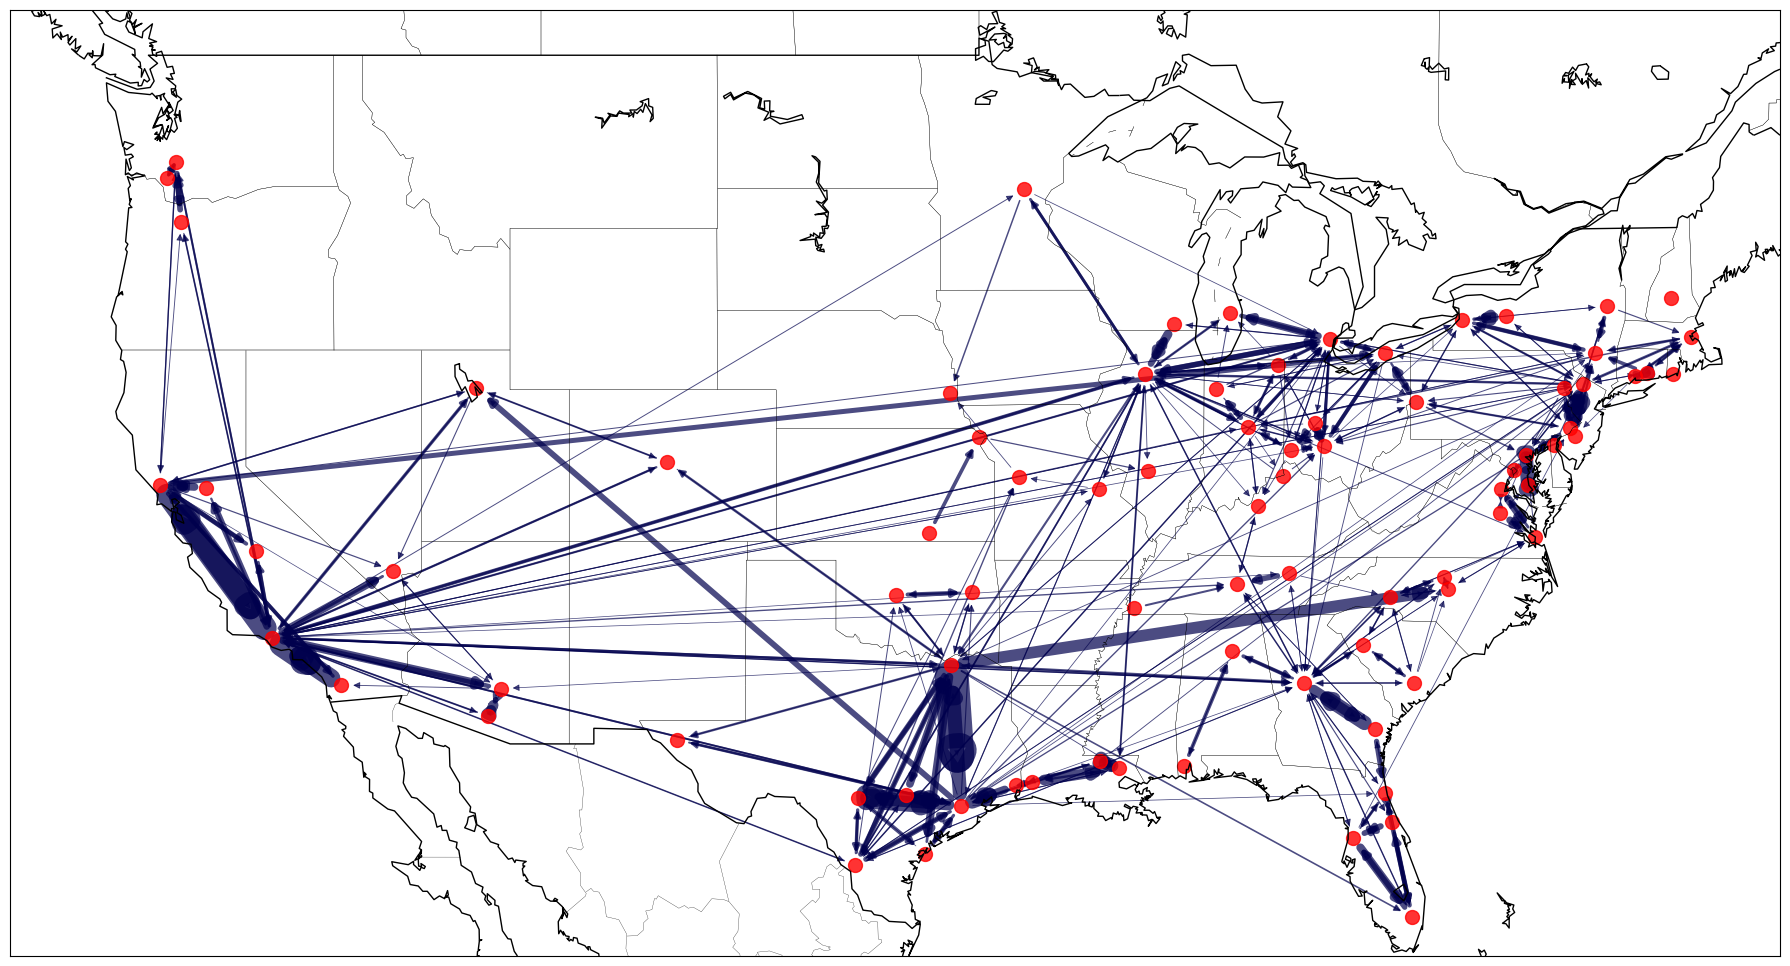

In [ ]:
cutoff = 500

for edge in G.edges:
    if edge in G_trimmed.edges and G.get_edge_data(edge[0], edge[1])["tons"] < cutoff:
        G_trimmed.remove_edge(edge[0], edge[1])

# width represents tons of cargo
width = [(G_trimmed.get_edge_data(edge[0], edge[1])["tons"]) / 1000 for edge in nx.edges(G_trimmed)]

#color represents change from original value
colors = [(avg_disruption_pct[edge] - 1) * 1000 for edge in nx.edges(G_trimmed)]


plt.figure(figsize = (18,18))
m = Basemap(
    projection='merc',
    llcrnrlon=-128,
    llcrnrlat=25,
    urcrnrlon=-68,
    urcrnrlat=50,
    lat_ts=0,
    resolution='l',
    suppress_ticks=True)

pos = {node: m(pos_df.loc[node]["longitude"], pos_df.loc[node]["latitude"]) for node in pos_df.index}
# add attributes to basemap
nx.draw_networkx_nodes(G = G_trimmed, pos = pos, nodelist = G.nodes(),
                       node_color = 'r', alpha = 0.8, node_size = 100)

nx.draw_networkx_edges(G = G_trimmed, pos = pos, width=width, alpha=0.7, arrows=True, edge_color=colors, edge_vmin=0.0, edge_vmax=1.0, edge_cmap=plt.cm.seismic)
m.drawcountries(linewidth = 1)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=1)
plt.tight_layout()
plt.show()

In [ ]:
pos_data = pd.read_csv(home + 'cfs_names_with_coordinates.csv')
pos_data.dropna(subset=["latitude", "longitude"], inplace=True)
# changed Portland (WA) coordinates
pos_data.at[126, 'longitude'] = -122.5463
pos_data.at[126, 'latitude'] = 46.1
pos_data.head()

,STPOSTAL,STFIPS,CFSMA,ST_MA,FAF,CFSAREANAM,SHORTNAME,latitude,longitude
0,AL,1,142,01-142,11,"Birmingham-Hoover-Talladega, AL CFS Area",Birmingham,52.479699,-1.902691
1,AL,1,380,01-380,12,"Mobile-Daphne-Fairhope, AL CFS Area",Mobile,30.691346,-88.043751
2,AL,1,99999,01-99999,19,Remainder of Alabama,Rest of AL,31.965194,-85.147562
3,AK,2,99999,02-99999,20,Alaska,Alaska,64.445961,-149.680909
4,AZ,4,38060,04-38060,41,"Phoenix-Mesa-Glendale, AZ CFS Area",Phoenix,33.448437,-112.074141


Using Miya's map above - animated simulation for removing nodes at random. For edges, just use remove_random_edge funciton instead. Then adjusted the edges opacity so the more popular ones would stand out. Then made the top ones a different color so those could stand out even more.


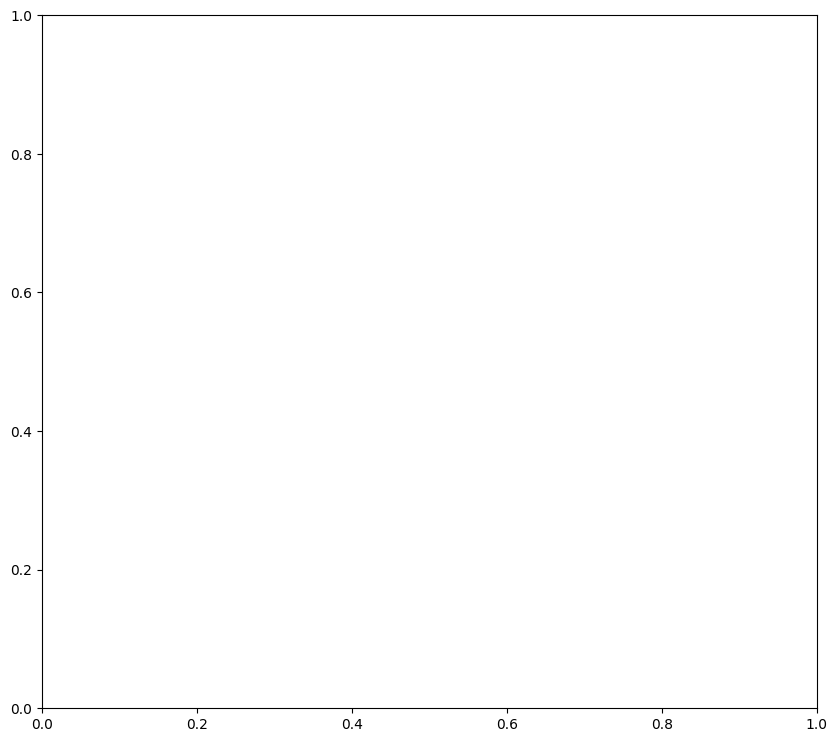

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [ ]:
def map_disruption(G, num_sims):
    pos_data = pd.read_csv(home+'cfs_names_with_coordinates.csv')
    pos_data.dropna(subset=["latitude", "longitude"], inplace=True)
    pos_data.at[126, 'longitude'] = -122.5463
    pos_data.at[126, 'latitude'] = 46.1
    pos_data.head()
    fig, ax = plt.subplots(figsize=(10, 9))

    m = Basemap(
        projection='merc',
        llcrnrlon=-130,
        llcrnrlat=30,
        urcrnrlon=-90,
        urcrnrlat=50,
        lat_ts=0,
        resolution='l',
        suppress_ticks=True)

    # translate long and lat to basemap coordinates
    mx, my = m(pos_data['longitude'].values, pos_data['latitude'].values)
    pos = {}
    for count, elem in enumerate(pos_data['SHORTNAME']):
        pos[elem] = (mx[count], my[count])

    def update(num):
        # Clear the previous plot
        ax.clear()
        G_copy = G.copy()
        removed_node = remove_random_node(G_copy)
        nx.draw_networkx_nodes(G=G_copy, pos=pos, nodelist=G_copy.nodes(),
                               node_color='r', alpha=0.8, node_size=100, ax=ax)

        # Calc max to set standard for opacities
        max_tons = max(G_copy[u][v]['tons'] for u, v in G_copy.edges())
        min_opacity = 0.3  # makes sure all edges are still visible

        # Calc edge opacities (0.0 - 1.0) = weight (tons) / max(weight)
        edge_opacities = {}
        for u, v, data in G_copy.edges(data=True):
            tons = data['tons']
            opacity = min_opacity + (tons / max_tons) * (1 - min_opacity)
            edge_opacities[(u, v)] = opacity

        # top 5 busiest edges by sorting by tons
        # did top 5 because undirected edges count as 2.
        # top 5 guarantees at least 3 highlighted edges
        sorted_edges = sorted(G_copy.edges(data=True), key=lambda x: x[2]['tons'], reverse=True)
        top_edges = set((u, v) for u, v, _ in sorted_edges[:5])  # top 5

        for (u, v) in G_copy.edges():
            color = 'blue' if (u, v) in top_edges else 'gray'
            alpha = edge_opacities[(u, v)]
            nx.draw_networkx_edges(G=G_copy, pos=pos, edgelist=[(u, v)], edge_color=color, alpha=alpha, arrows=True, ax=ax)

        m.drawcountries(linewidth=1, ax=ax)
        m.drawstates(linewidth=0.2, ax=ax)
        m.drawcoastlines(linewidth=1, ax=ax)

        ax.set_title(f"Simulation {num + 1}, Removed Node: {removed_node}")

    # frames = num frames in animation
    # interval = delay between frames (ms)
    ani = FuncAnimation(fig, update, frames=num_sims, repeat=True, interval=800)
    plt.show()
map_disruption(G_copy2, num_sims)

Output of simulation because colab has trouble doing it:

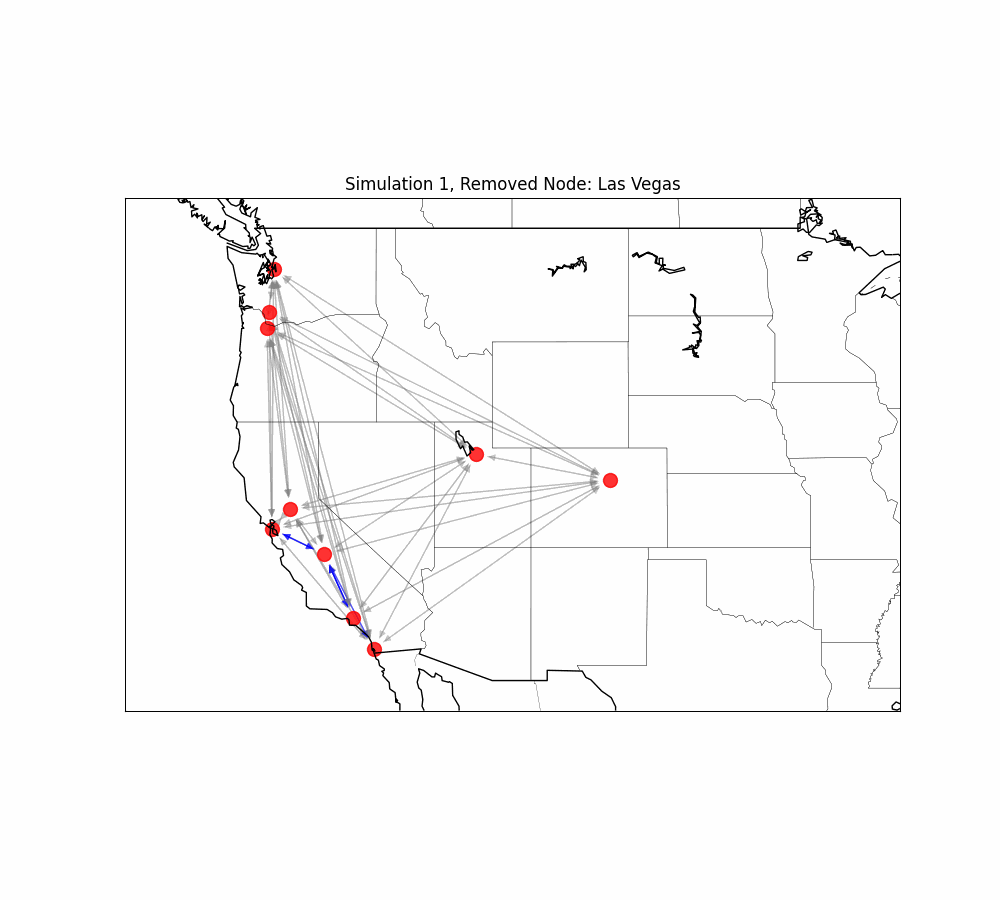

Still need to calc average after removing nodes then do route-planning algorithm

Alternate Path from Los Angeles to San Francisco is:  ['Los Angeles', 'Fresno', 'San Francisco']
Alternate Path Length:  384.93537645690367


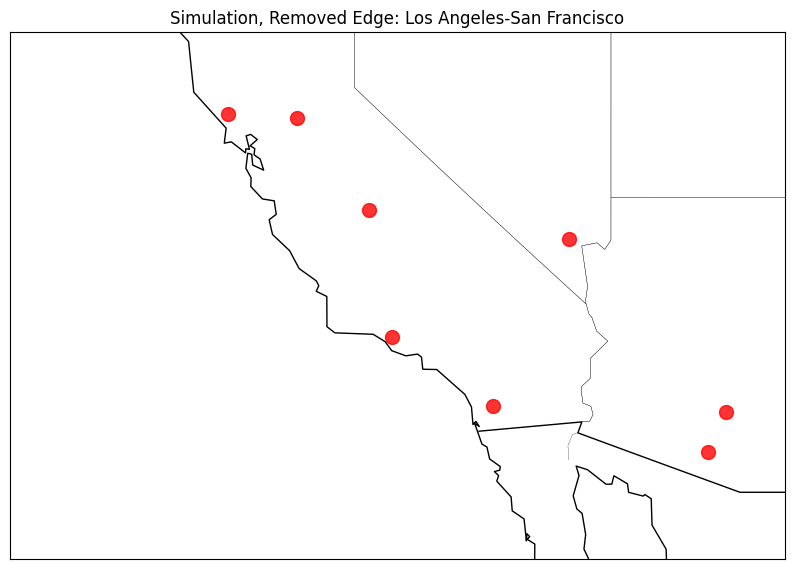

In [ ]:
frame = 0

# Just a demo of removing an edge
def edge_removal_demo(G, orig, dest):
    G_copy = G.copy()
    fig, ax = plt.subplots(figsize=(10, 9))

    m = Basemap(
        projection='merc',
        llcrnrlon=-128,
        llcrnrlat=30,
        urcrnrlon=-110,
        urcrnrlat=40,
        lat_ts=0,
        resolution='l',
        suppress_ticks=True)

    # translate long and lat to basemap coordinates
    pos = {node: m(pos_df.loc[node]["longitude"], pos_df.loc[node]["latitude"]) for node in pos_df.index}
    def update(num):
        global frame
        # Clear the previous plot
        ax.clear()
        nx.draw_networkx_nodes(G=G_copy, pos=pos, nodelist=G_copy.nodes(),
                               node_color='r', alpha=0.8, node_size=100, ax=ax)

        match frame:
            case 0:
                for (u, v) in G_copy.edges():
                    nx.draw_networkx_edges(G=G_copy, pos=pos, edgelist=[(u, v)], edge_color='gray', alpha=0.3, arrows=True, ax=ax)
            case 1:
                for (u, v) in G_copy.edges():
                    color = 'blue' if (u == orig and v == dest) else 'gray'
                    alpha = 1.0 if (u == orig and v == dest) else 0.3
                    nx.draw_networkx_edges(G=G_copy, pos=pos, edgelist=[(u, v)], edge_color=color, alpha=alpha, arrows=True, ax=ax)
            case 2:
                G_copy.remove_edge(orig, dest)
                shortest_path = find_alt_path(G_copy, orig, dest)
                for (u, v) in G_copy.edges():
                    color = 'red' if (u, v) in [(shortest_path[i], shortest_path[i + 1]) for i in range(len(shortest_path) - 1)] else 'gray'
                    alpha = 1.0 if (u, v) in [(shortest_path[i], shortest_path[i + 1]) for i in range(len(shortest_path) - 1)] else 0.3
                    nx.draw_networkx_edges(G=G_copy, pos=pos, edgelist=[(u, v)], edge_color=color, alpha=alpha, arrows=True, ax=ax)
        frame += 1

        m.drawcountries(linewidth=1, ax=ax)
        m.drawstates(linewidth=0.2, ax=ax)
        m.drawcoastlines(linewidth=1, ax=ax)

        ax.set_title(f"Simulation, Removed Edge: {orig}-{dest}")

    # frames = num frames in animation
    # interval = delay between frames (ms)
    ani = FuncAnimation(fig, update, frames=3, repeat=True, interval=800)
    ani.save("anim.gif")
    plt.show()
edge_removal_demo(G_trimmed, "Los Angeles", "San Francisco")

# Interstate Map

In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local
!conda update conda -y -q
!conda config --prepend channels conda-forge
!conda install -q -y --prefix /usr/local python=3.8 pygmt

import sys
import os
sys.path.append('/usr/local/lib/python3.8/site-packages')
os.environ["GMT_LIBRARY_PATH"]="/usr/local/lib"

In [ ]:
import geopandas as gpd
import pygmt
primary_roads = gpd.read_file(
    'https://www2.census.gov/geo/tiger/TIGER2019/PRIMARYROADS/tl_2019_us_primaryroads.zip'
)
primary_roads.head()

In [ ]:
# The dataset contains different road types listed in the RTTYP column,
# here we select the following ones to plot:
roads_common = primary_roads[primary_roads.RTTYP == "M"]  # Common name roads
roads_state = primary_roads[primary_roads.RTTYP == "S"]  # State recognized roads
roads_interstate = primary_roads[primary_roads.RTTYP == "I"]  # Interstate roads

fig = pygmt.Figure()

# Define target region
region = [-130, -68, 25, 50]  # xmin, xmax, ymin, ymax

title = r"Main roads of the US"  # \047 is octal code for '
fig.basemap(region=region, projection="M25c", frame=["f"])
fig.coast(borders=["1/1p,black", "2/0.5p,black"], land="gray", water="lightblue", shorelines="1/0.5p")

fig.plot(data=roads_interstate, pen="2p,red", label="Interstate")
fig.legend()